<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/knn/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN Analysis — Premier League Team Positions

Objectif :

Prédire la position finale des équipes en milieu ou fin de saison.

Utiliser la proximité entre équipes en termes de statistiques pour estimer leur classement.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.inspection import permutation_importance

## Load and Inspect Dataset

In [4]:
# Load the aggregated team-season dataset
from pathlib import Path
import pandas as pd
import numpy as np

candidate_paths = [
    Path('team_season_aggregated.csv'),
    Path('../data/processed/team_season_aggregated.csv'),
    Path('../../../data/processed/team_season_aggregated.csv'),
]

agg_path = next((p for p in candidate_paths if p.exists()), None)
if agg_path is None:
    raise FileNotFoundError(
        'team_season_aggregated.csv not found! '
        'Please run data_preprocessing.ipynb first to create this file.'
    )

print(f'✅ Loading aggregated dataset: {agg_path}')
df_agg = pd.read_csv(agg_path)

print(f'\nDataset shape: {df_agg.shape}')
print(f'Seasons: {sorted(df_agg["Season"].unique())}')
print(f'Teams per season: ~{len(df_agg) // df_agg["Season"].nunique()}')

print('\nSample data:')
print(df_agg.head())

print('\nTarget variable (Final_Position) distribution:')
print(df_agg['Final_Position'].value_counts().sort_index())

✅ Loading aggregated dataset: ..\..\..\data\processed\team_season_aggregated.csv

Dataset shape: (500, 35)
Seasons: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Teams per season: ~20

Sample data:
    Season  Season_encoded        Team  Matches_Played  Home_Matches  \
0  2000-01               0  Man United              38            19   
1  2000-01               0     Arsenal              38            19   
2  2000-01               0   Liverpool              38            19   
3  2000-01               0       Leeds              38            19   
4  2000-01               0     Ipswich              38            19   

   Away_Matches  Wins  Draws  Losses  Home_Wins  ...  Yellow_Cards  Red_Cards  \
0            19    24      8       6         15  ...      

In [5]:
missing = df_agg.isnull().sum()
if missing.any():
    print("\n⚠️ Missing values detected:")
    print(missing[missing > 0])
else:
    print("\n✅ No missing values detected.")


✅ No missing values detected.


## Feature selection and target

In [6]:
feature_cols = [
    'Team_encoded', 'Season_encoded',
    'Wins', 'Draws', 'Losses',
    'Goals_Scored', 'Goals_Conceded', 'Goal_Difference',
    'Avg_Goals_Scored', 'Avg_Goals_Conceded',
    'Total_Shots', 'Total_Shots_On_Target',
    'Avg_Shots', 'Avg_Shots_On_Target',
    'Shot_Accuracy',
    'Clean_Sheets', 'Clean_Sheet_Rate',
    'Yellow_Cards', 'Red_Cards', 'Fouls', 'Corners',
    'Win_Rate', 'Home_Win_Rate', 'Away_Win_Rate',
    'Points_Per_Game'
]

available_features = [col for col in feature_cols if col in df_agg.columns]
missing_features = [col for col in feature_cols if col not in df_agg.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print(f"✅ All {len(available_features)} features found.")

target_col = 'Final_Position'


✅ All 25 features found.


## Train-Test Split

In [7]:
# --- 4️⃣ Split train/test (80/20) ---
X = df_agg[available_features]
y = df_agg[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain shape: {X_train.shape} | Test shape: {X_test.shape}")


Train shape: (400, 25) | Test shape: (100, 25)


## Standardisation

In [8]:
# --- 5️⃣ Standardisation des features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
knn = KNeighborsRegressor(n_neighbors=5, metric='minkowski')
knn.fit(X_train_scaled, y_train)

y_pred_train = knn.predict(X_train_scaled)
y_pred_test = knn.predict(X_test_scaled)

In [10]:
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} → MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

print("\n📈 Performance Summary — Base KNN:")
evaluate(y_train, y_pred_train, label="Train")
evaluate(y_test, y_pred_test, label="Test")


📈 Performance Summary — Base KNN:
Train → MAE: 1.096 | RMSE: 1.401 | R²: 0.9418
Test → MAE: 1.480 | RMSE: 1.967 | R²: 0.8766


## GridSearch


In [11]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)

print("\n✅ Best KNN Hyperparameters:")
print(grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
y_pred_test_best = best_knn.predict(X_test_scaled)

print("\n📈 Performance Summary — Optimized KNN:")
evaluate(y_test, y_pred_test_best, label="Test Optimized")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best KNN Hyperparameters:
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

📈 Performance Summary — Optimized KNN:
Test Optimized → MAE: 1.270 | RMSE: 1.590 | R²: 0.9194

✅ Best KNN Hyperparameters:
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

📈 Performance Summary — Optimized KNN:
Test Optimized → MAE: 1.270 | RMSE: 1.590 | R²: 0.9194


## Actual vs Predicted

In [12]:

mae_test = mean_absolute_error(y_test, y_pred_test_best)
r2_test = r2_score(y_test, y_pred_test_best)

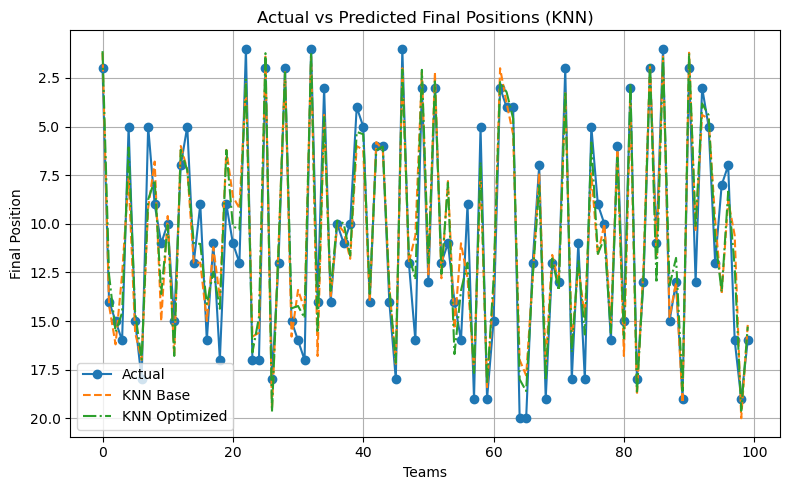

In [13]:
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="KNN Base", linestyle='--')
plt.plot(y_pred_test_best, label="KNN Optimized", linestyle='-.')
plt.title("Actual vs Predicted Final Positions (KNN)")
plt.xlabel("Teams")
plt.ylabel("Final Position")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


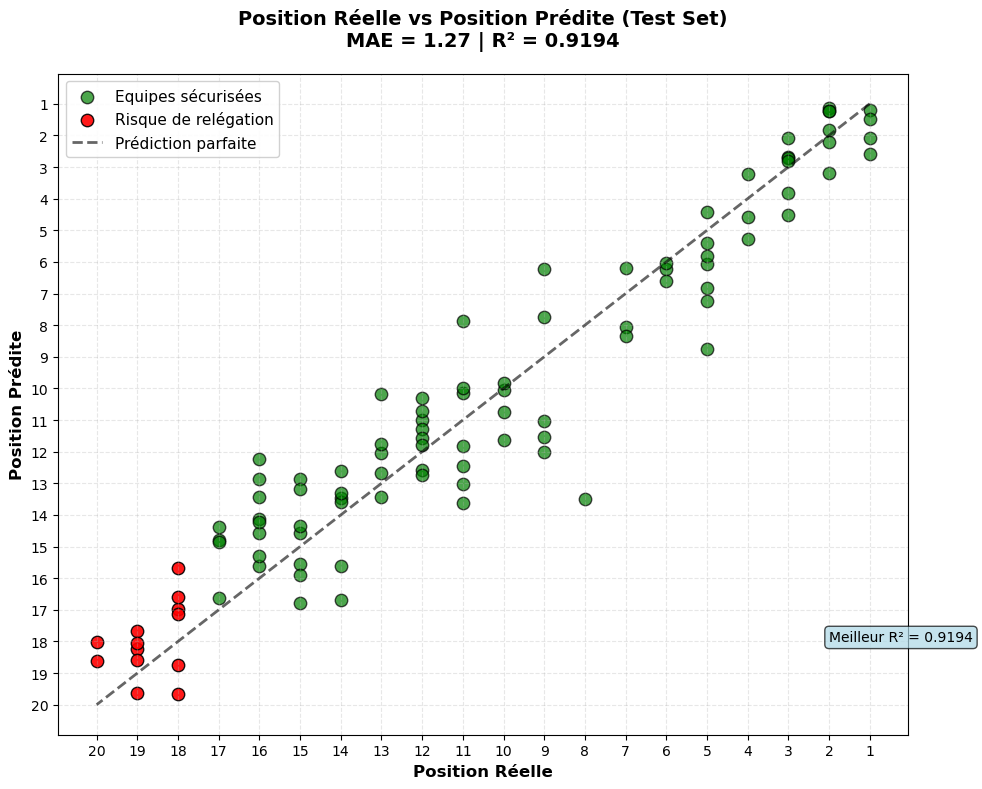

In [14]:
# --- Visualisation : Actual vs Predicted ---
plt.figure(figsize=(10, 8))

# Définir la zone de relégation (positions 18-20)
relegation_zone = (y_test >= 18) & (y_test <= 20)

# Prédictions sur le test set
y_pred_test = best_knn.predict(X_test_scaled)

# Graphique avec couleurs selon la zone
plt.scatter(y_test[~relegation_zone], y_pred_test[~relegation_zone], 
            color='green', alpha=0.7, s=80, label='Equipes sécurisées', edgecolors='k')
plt.scatter(y_test[relegation_zone], y_pred_test[relegation_zone], 
            color='red', alpha=0.9, s=80, label='Risque de relégation', edgecolors='k')

# Ligne de prédiction parfaite
plt.plot([1, 20], [1, 20], 'k--', lw=2, alpha=0.6, label='Prédiction parfaite')

# Labels et titre
plt.xlabel("Position Réelle", fontsize=12, fontweight='bold')
plt.ylabel("Position Prédite", fontsize=12, fontweight='bold')
plt.title(f"Position Réelle vs Position Prédite (Test Set)\nMAE = {mae_test:.2f} | R² = {r2_test:.4f}", 
          fontsize=14, fontweight='bold', pad=20)

# Inversion des axes pour avoir la position 1 en haut (comme un classement)
plt.gca().invert_yaxis()  
plt.gca().invert_xaxis()

# Améliorations visuelles
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(range(1, 21))
plt.yticks(range(1, 21))

# Ajouter quelques annotations
plt.text(2, 18, f"Meilleur R² = {r2_test:.4f}", fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

## Error analysis

In [15]:
errors = y_test - y_pred_test_best
print("\n🎯 Error Distribution (Test Set):")
print(f"Mean error: {errors.mean():.3f} | Std: {errors.std():.3f} | Min: {errors.min():.3f} | Max: {errors.max():.3f}")

for tol in [1, 2, 3]:
    acc = (np.abs(errors) <= tol).sum() / len(errors) * 100
    print(f"Accuracy within ±{tol} position(s): {acc:.1f}%")


🎯 Error Distribution (Test Set):
Mean error: 0.129 | Std: 1.592 | Min: -5.502 | Max: 3.776
Accuracy within ±1 position(s): 50.0%
Accuracy within ±2 position(s): 80.0%
Accuracy within ±3 position(s): 94.0%


In [16]:
result = permutation_importance(best_knn, X_test_scaled, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result['importances_mean']})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\n📊 Feature Importance (Top 10):")
print(importance_df.head(10))


📊 Feature Importance (Top 10):
               Feature  Importance
4               Losses    0.018369
24     Points_Per_Game    0.018132
21            Win_Rate    0.017054
2                 Wins    0.017054
22       Home_Win_Rate    0.015244
18           Red_Cards    0.004652
6       Goals_Conceded    0.004456
9   Avg_Goals_Conceded    0.004456
7      Goal_Difference    0.004374
15        Clean_Sheets    0.004315


C:\Users\Mega Pc\AppData\Local\Temp\ipykernel_37060\1747000265.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


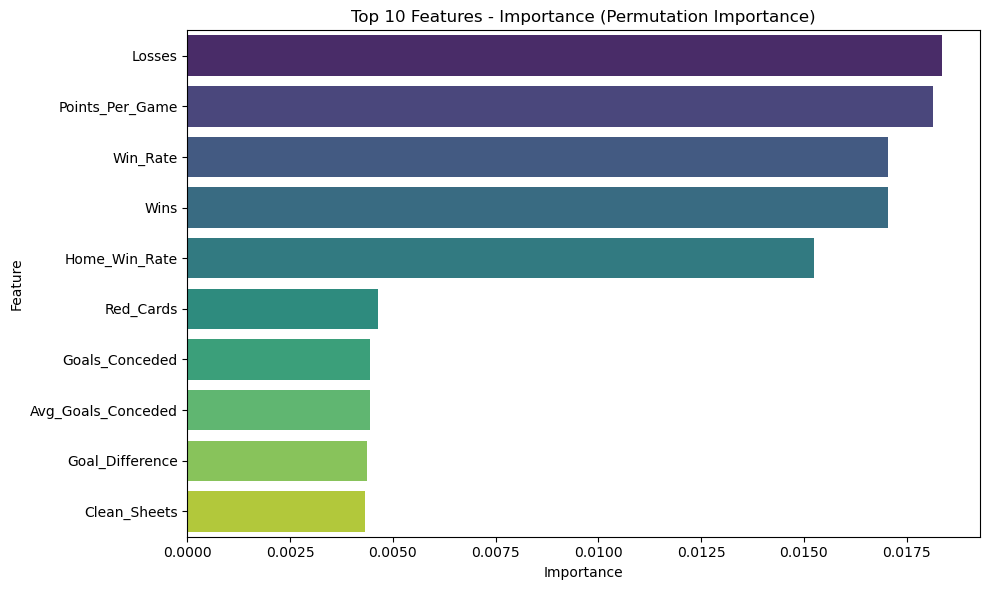

In [17]:
# Trier par importance décroissante et garder les 10 premières
top_features = importance_df.sort_values('Importance', ascending=False).head(10)

# Tracer
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Features - Importance (Permutation Importance)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 📊 Summary: KNN Model

This project aimed to accurately predict Premier League team final positions using 25 seasons of historical data and the K-Nearest Neighbors algorithm.

## 🔍 KNN Regression: Final Position Prediction

**Goal:**  
Predict exact final rankings using statistical similarity between teams.

**Optimized Parameters:**
- Neighbors: 9
- Distance: Manhattan (p=1) 
- Weighting: Distance-based

**Results:**
- **MAE:** 1.270 positions
- **R² Score:** 0.9194 (91.9% variance explained)
- **±2 Position Accuracy:** 80.0%
- **±3 Position Accuracy:** 94.0%

## 🎯 Performance-Based Risk Assessment

**Implicit Relegation Analysis:**
- Clear separation of relegation-threatened teams (positions 18-20)
- Visual confirmation via scatter plots with risk zone highlighting
- Borderline team identification (positions 15-17)

## 🧠 Key Predictive Features

**Permutation Importance Analysis:**
1. **Losses** - Primary relegation indicator
2. **Points Per Game** - Overall performance metric  
3. **Win Rate** - Season consistency
4. **Wins** - Direct success factor
5. **Home Win Rate** - Home advantage impact

## ✅ Conclusion

This KNN-based solution successfully predicts team final positions with high accuracy using similarity-based learning. The model provides:

- **Precise ranking forecasts** (MAE: 1.27 positions)
- **Excellent explanatory power** (R²: 0.919)
- **Intuitive similarity logic** for easy interpretation
- **Reliable risk assessment** through position analysis
- **Comprehensive team evaluation** across all table positions

